# Assignment 5
First lets import all the libraries.

In [1]:
import numpy as np
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import tensorflow as tf
import numpy as np
import sys; sys.path.insert(0, '..')

## Define the Book class
This class holds all necessary functions and data regarding handling with the christian bible.

In [2]:
import numpy as np
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import os, pickle

class Book:
    def __init__(self, file_name='bible.txt'):
        pickle_name = 'book_text.pckl'
        if os.path.exists(pickle_name):
            with open(pickle_name, 'rb') as f:
                self._book_text = pickle.load(f)
        else:
            with open(file_name) as f:
                book = f.read()
                book = book.lower()
                tokenizer = RegexpTokenizer(r'\w+')
                book = [w.lower() for w in tokenizer.tokenize(book)]
                self._book_text = book
            with open(pickle_name, 'wb') as f:
                pickle.dump(book, f)

        print("Unique words: " + str(len(Counter(self._book_text))))


    def create_dictionaries(self, vocabulary_size):
        '''Create a dict mapping words to word ids. It works by finding the
        `vocabulary_size` most common words and assigning ids based on the
        frequency. The most common word will have id 1, the second most common
        one id 2, and so forth. All other words (with the key "UNKNOWN") will
        have id 0.

        Parameters
        ----------
        vocabulary_size :   int
                            Number of most common words to create ids for
        '''
        words_and_count = Counter(self._book_text).most_common(vocabulary_size - 1)

        word2id = {word.lower(): word_id for word_id, (word, _) in enumerate(words_and_count, 1)}
        word2id["UNKNOWN"] = 0

        id2word = dict(zip(word2id.values(), word2id.keys()))

        # Map words to ids
        self._book = [word2id.get(word, 0) for word in self._book_text]

        self._word2id = word2id
        self._id2word = id2word


    def words2ids(self, words):
        if type(words) == list or type(words) == range or type(words) == np.ndarray:
            return [self._word2id.get(word.lower(), 0) for word in words]
        else:
            return self._word2id.get(words, 0)

    def ids2words(self, ids):
        if type(ids) == list or type(ids) == range or type(ids) == np.ndarray:
            return [self._id2word.get(wordid, "UNKNOWN") for wordid in ids]
        else:
            return self._id2word.get(ids, 0)


    def get_training_batch(self, batch_size, skip_window):
        valid_indices = range(skip_window, len(self._book) - (skip_window + 1))
        context_range = [x for x in range(-skip_window, skip_window + 1) if x != 0]
        wordid_contextid_pairs = [(word_id, word_id + shift) for word_id in
                valid_indices for shift in context_range]

        np.random.shuffle(wordid_contextid_pairs)

        counter = 0
        words = np.zeros((batch_size), dtype = np.int32)
        contexts = np.zeros((batch_size, 1), dtype = np.int32)

        for word_index, context_index in wordid_contextid_pairs:
            words[counter] = self._book[word_index]
            contexts[counter, 0] = self._book[context_index]
            counter += 1

            if counter == batch_size:
                yield words, contexts
                counter = 0



## SkipGramModel
Here we are defining a class representing a skip gram model which contains our network. Its a convenience object on that we perform the learning step later on.

In [3]:
# A helper for creating the weights and biases later.
weights_n = 0
def get_weights_and_bias(shape, shape_b=None, dtype=tf.float32,
        initializer_w=tf.random_uniform_initializer(-1.0, 1.0),
        initializer_b=tf.zeros_initializer()):
    if not shape_b:
        shape_b = shape[-1:]

    global weights_n

    weights_n += 1
    with tf.variable_scope('weights%d' % weights_n):
        return (
                tf.get_variable('W', initializer=initializer_w,shape=shape, dtype=dtype),
                tf.get_variable('b', shape=shape_b, initializer=initializer_b)
                )


class SkipGramModel(object):
    '''A minimal customizable SkipGramModel for predicting one context word from
    1 target word.

    Attributes
    ----------
    target_word_id  :   tf.placeholder of shape (batch,)
                        Batch of input word ids to predict for
    target_context_id   :   tf.placeholder of shape (batch, 1)
                            Batch of target context word ids
    loss    :   tf.op
                operation for the NCE loss
    merged  :   tf.summary.scalar
                Summary var for the loss
    train_step  :   tf.Variable
                    optimizer training step
    '''

    def __init__(self, vocabulary_size, embedding_size, validation_set, **kwargs):
        '''
        Parameters
        ----------
        vocabulary_size :   int
                            Number of classes to predict from (the size of the
                            considerer vocabulary)
        embedding_size  :   int
                            Dimensionality of the space to project the words
                            onto. Length of the vectors representing a word
        validation_set  :   Set of word ids to check the similarity for

        learning_rate   :   float
                            Optimizer learning rate
        optimizer       :   str
                            Name of the tf optimizer to use (e.g.  "GradientDescent")
        noise_samples   :   int
                            Number of noise samples for NCE sampling
        '''
        ###########################
        #  Extract relevant args  #
        ###########################
        optimizer_cls = getattr(tf.train, kwargs.get('optimizer', 'GradientDescent') + 'Optimizer')
        learning_rate = kwargs.get('learning_rate', 1)
        noise_samples = kwargs.get('noise_samples', 64)

        ############################################
        #  Input word id + target context word id  #
        ############################################
        self.target_word_id    = tf.placeholder(tf.int32, shape=(None,), name='target')
        self.target_context_id = tf.placeholder(tf.int32, shape=(None, 1), name='target')

        ##################
        #  Hidden layer  #
        ##################
        W_context, _ = get_weights_and_bias((vocabulary_size, embedding_size))
        self.a_h = tf.nn.embedding_lookup(W_context, self.target_word_id)
        
        ##################
        #  Output layer  #
        ##################
        # notice that - strangely - the weights matrix must be transposed from
        # what you would use for multiplying a_h * W. This seems to be a quirk
        # of tf nce_loss
        initializer = tf.random_normal_initializer(stddev=1 /
                np.sqrt(embedding_size))
        W_target, b_target = get_weights_and_bias((vocabulary_size, embedding_size),
                shape_b=(vocabulary_size, ), initializer_w=initializer)

        ##########
        #  Loss  #
        ##########
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(
                    tf.nn.nce_loss(
                        weights=W_target,
                        biases=b_target,
                        labels=self.target_context_id,
                        inputs=self.a_h,
                        num_sampled=noise_samples,
                        num_classes=vocabulary_size
                        )
                    )

        #########################
        #  TensorBoard logging  #
        #########################
        with tf.variable_scope('summary'):
            tf.summary.scalar('loss', self.loss)
            self.merged = tf.summary.merge_all()

        self.train_step = optimizer_cls(learning_rate).minimize(self.loss)


        ########################################
        #  Accuracy for a fixed set of words.  #
        ########################################
        # Compute the cosine similarity between minibatch examples and all
        # embeddings. Copypasta from stackoverflow
        norm = tf.sqrt(tf.reduce_sum(tf.square(W_context), 1, keep_dims=True))
        normalized_embeddings = W_context / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                validation_set)
        self.similarity = tf.matmul(valid_embeddings, normalized_embeddings,
                transpose_b=True)
        # get the 8 closeset, because the first closest is always the word
        # itself.
        self.closest_words = tf.nn.top_k(self.similarity, 8).indices[:, 1:]

    def save(self, session):
        '''Save the model.'''
        saver = tf.train.Saver()
        saver.save(session, './skip-gram.ckpt')    

    def run_training_step(self, session, inputs, labels):
        '''Run one training step.

        Returns
        -------
        tuple
                Tuple with loss, array of closest ids for the validation set,
                and the summary variable for saving
        '''

        _, loss, closest, summary = session.run([self.train_step, self.loss,
            self.closest_words, self.merged], feed_dict={
                self.target_word_id: inputs,
                self.target_context_id: labels,
                })

        return loss, closest, summary
    
    def word2vec(self, session, inputs):
        '''Gets the vector representation of several input words.
        TODO
        '''
        return session.run([self.a_h], feed_dict={self.target_word_id: inputs})

## The Main
Now after initializing all necessary

In [4]:
# Define the parameters for our model that were given on the assignment sheet.
vocabulary_size = 10000
embedding_size = 64
skip_window = 1
optimizer = 'GradientDescent'
learning_rate = 1
epochs = 10
batch_size = 128

# RNG related
SEED = 5
np.random.seed(SEED)
tf.set_random_seed(SEED)

# Write results to file at this location later.
summary_dir = './summary/train/'

# Create a Book object with all ids and words in it from the christian bible.
book = Book()
book.create_dictionaries(vocabulary_size)

Unique words: 13082


## Test the mapping functions
Here we are simply looking for some words and check whether the result of words2ids results in the same output when feeded into ids2words.

In [ ]:
words, contexts = next(book.get_training_batch(1, 10))
words = ['the', 'god', 'jesus']
ids = book.words2ids(words)
assert words == book.ids2words(ids), 'Shits not working, yo.'

## Train the model

In [5]:
# the validation set is fixed
validation_set = book.words2ids(['5', 'make', 'god', 'jesus', 'year', 'sin', 'israel'])

# We instantiate the model
model = SkipGramModel(
    vocabulary_size, 
    embedding_size, 
    validation_set,
    optimizer = optimizer, 
    learning_rate = learning_rate
)

In [ ]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Initialize the file writer for our results later
    train_writer = tf.summary.FileWriter(summary_dir, session.graph)
    
    for epoch in range(epochs):
        for i, (inputs, context) in enumerate(book.get_training_batch(batch_size, skip_window)):
            loss, closest, summary = model.run_training_step(session, inputs, context)
            # Every so often, write the loss summary tensor
            if i % 20 == 0:
                train_writer.add_summary(summary, epoch*i)

        ##########################
        #  Print the validation  #
        ##########################
        print("loss=%3.4f" % (loss))
        for idx, word in enumerate(validation_set):
            closest_words = ' '.join(book.ids2words(closest[idx, :]))
            word_id = book.ids2words(word)
            print("Closest for %s: %s" % (word_id, closest_words))
            
    model.save(session)

## Visualize with T-SNE

In [6]:
## Restore all the variables.
#saver = tf.train.Saver()
#with tf.Session() as session:
#    session.run(tf.global_variables_initializer())
#    # Restore variables from disk.
#    saver.restore(session, "./skip-gram.ckpt")
#    print("Model restored.")

INFO:tensorflow:Restoring parameters from ./skip-gram.ckpt
Model restored.


In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_components = 2
perplexity = 30.0
tsne_model = TSNE(n_components=n_components, perplexity=perplexity)
plot_ids = np.arange(0, 500)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    word_vecs = model.word2vec(session, plot_ids)[0]

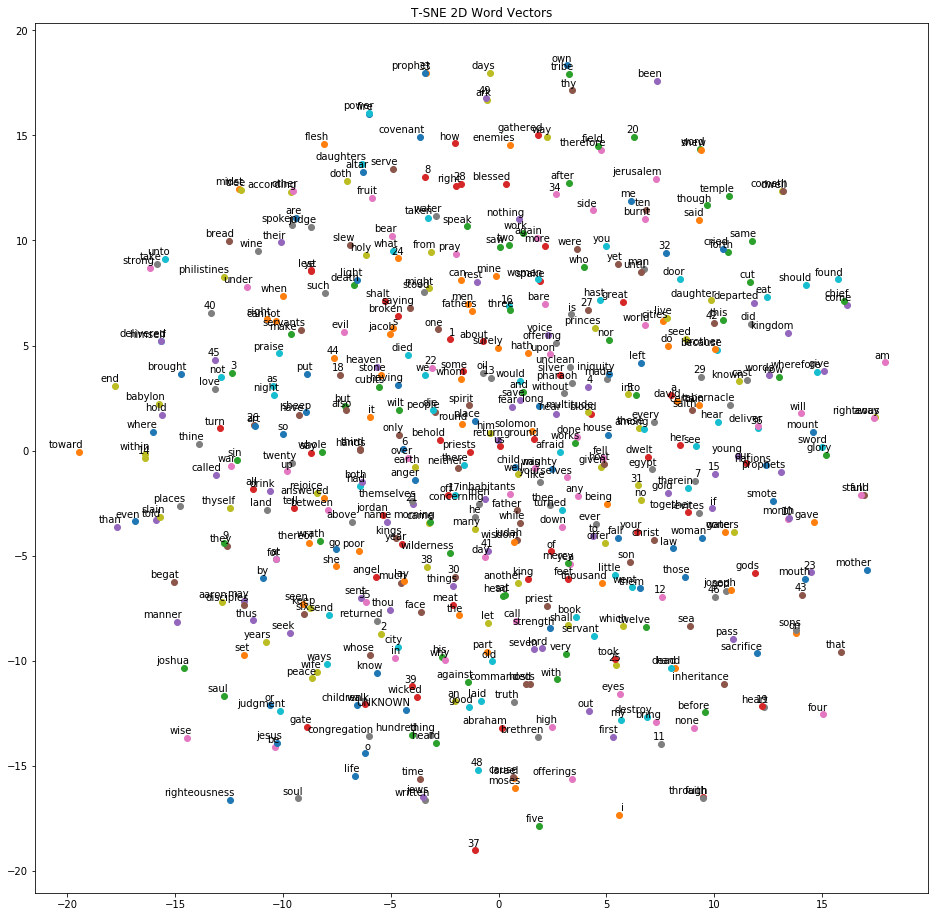

In [13]:
reduced_word_vecs = tsne_model.fit_transform(word_vecs)

x = []
y = []
labels = book.ids2words(plot_ids)
for vec in reduced_word_vecs:
    x.append(vec[0])
    y.append(vec[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.title('T-SNE 2D Word Vectors')
    plt.annotate(
        labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom'
    )
plt.show()